# DNN regressors

This file trains 3 different NN Regressors and a Gaussian Process Regressor.

1) A DNN to predict mean O18 ratios.

2) A hybrid output DNN to predict mean and variances.

3) A DNN to predict just variances of O18 ratios.

4) A GPR regressor to predict mean O18 ratios and variances.

At the end of the colab, there's driver code to translate the model to isoscapes, and some additional code to render GIFs. Every model seems to predict means very well, but with mixed results to predict variance. The hybrid model seems to underestimate variance. The variance-only model produces gibberish. And GPR *I can't tell* looks good but intuitively it seems to underproduce variances as well.

In [1]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from typing import List

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
DATAFRAME_PATH = "/MyDrive/amazon_rainforest_files/monthly_large.csv" #@param
RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
MODEL_SAVE_LOCATION = "/MyDrive/amazon_rainforest_files/" #@param
OUTPUT_RASTER_BASE = "/MyDrive/amazon_rainforest_files/" #@param

def get_dataframe_path_from_params() -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{DATAFRAME_PATH}"

def get_model_save_location(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{MODEL_SAVE_LOCATION}{filename}"

def get_raster_path_from_params(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{RASTER_BASE}{filename}"

def get_output_raster_path_from_params(filename) -> str:
    root = GDRIVE_BASE if GDRIVE_BASE else ""
    return f"{root}{OUTPUT_RASTER_BASE}{filename}"


In [2]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Mounted at /content/drive


In [3]:
def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

#Data preparation


In [4]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(get_dataframe_path_from_params())
df = df.rename(columns={
    "cellulose_oxygen_ratio": "O18",
})
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Reformat the "month_of_year" column into 12 separate binary columns.
def categorize_months(df: pd.DataFrame):
  return pd.get_dummies(df, columns=['month_of_year'])
df_expanded = categorize_months(df)

train, test = train_test_split(df_expanded, test_size=0.25, random_state=25)
Y_train = train['O18']
Y_test = test['O18']

# Sample site coordinates are redundant with lat and lon columns.
X_train = train.drop(['O18', 'sample_site_lon', 'sample_site_lat'], axis=1)
X_test = test.drop(['O18', 'sample_site_lon', 'sample_site_lat'], axis=1)

# 1) Neural network to predict O18 ratios

Model definition:

In [ ]:
def train_means(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float):
    shared_layers = []
    for num_nodes in hidden_layers:
        shared_layers.append(layers.Dense(
            num_nodes,
            activation='sigmoid'))

    num_inputs = X.shape[1]
    inputs = keras.Input(shape=(num_inputs,))
    x = inputs
    for shared_layer in shared_layers:
        x = shared_layer(x)

    # Output is mean. Connect to shared nodes.
    mean_output_layer = layers.Dense(1, activation='linear', name='mean_output')
    mean_output_node = mean_output_layer(x)

    model = keras.Model(inputs=inputs, outputs=[mean_output_node])

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    print (model.summary())
    history = model.fit(X, Y, epochs=epochs, verbose=False, batch_size=batch_size, validation_split=0.2, shuffle=True)
    return history, model

Train and evaluate results:

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 19)]              0         
                                                                 
 dense_28 (Dense)            (None, 24)                480       
                                                                 
 dense_29 (Dense)            (None, 40)                1000      
                                                                 
 mean_output (Dense)         (None, 1)                 41        
                                                                 
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
None


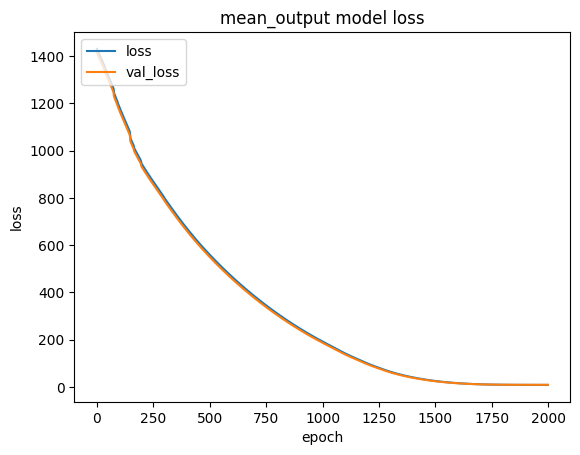

43/43 [==============================] - 0s 871us/step - loss: 8.2180


8.21796989440918

In [ ]:
# Train and render results.
history, means_model = train_means(X_train, Y_train, hidden_layers=[24, 40], epochs=2000, batch_size=500, lr = 0.0001)
render_plot_loss(history, "mean_output")
means_model.evaluate(x=X_test, y=Y_test)

In [ ]:
means_model.save(get_model_save_location("dnn_means.h5"), save_format="h5")

# 2) Hybrid O18 + Variances model

Model definition:

In [ ]:
# Fitting would go on much longer than it needs to unless we signal for it
# to stop early. If val_loss hasn't changed for 300 iterations, stop.
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=300, min_delta=0.01, verbose=1)
terminate_nan = keras.callbacks.TerminateOnNaN()

def mean_and_var_loss(y_real, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_real = math_ops.cast(y_real, y_pred.dtype)
  mean = y_pred[..., 0::2]
  variance = y_pred[..., 1::2]
  res = tf.square(mean - y_real) + tf.math.square(variance - tf.square(mean - y_real))
  return tf.reduce_mean(res, axis=-1)

def train_means_and_vars(X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float):
  inputs = keras.Input(shape=(X.shape[1],))
  x = inputs
  for layer_size in hidden_layers:
    x = keras.layers.Dense(layer_size, activation=tf.nn.softsign)(x)
  mean_output = keras.layers.Dense(1, activation='linear', name='mean_output',
                                   kernel_regularizer=keras.regularizers.L2(0.01))(x)
  var_output = keras.layers.Dense(1, activation=tf.nn.softsign, name='var_output')(x)
  outputs = keras.layers.concatenate([mean_output, var_output])
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss=mean_and_var_loss, metrics=['mae'])
  model.summary()
  history = model.fit(X, Y, verbose=0, epochs=epochs, batch_size=batch_size,
            validation_split=0.4, callbacks=[terminate_nan, early_stop])
  return history, model


Build and evaluate

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 80)           1520        ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 80)           6480        ['dense_2[0][0]']                
                                                                                                  
 mean_output (Dense)            (None, 1)            81          ['dense_3[0][0]']                
                                                                                            

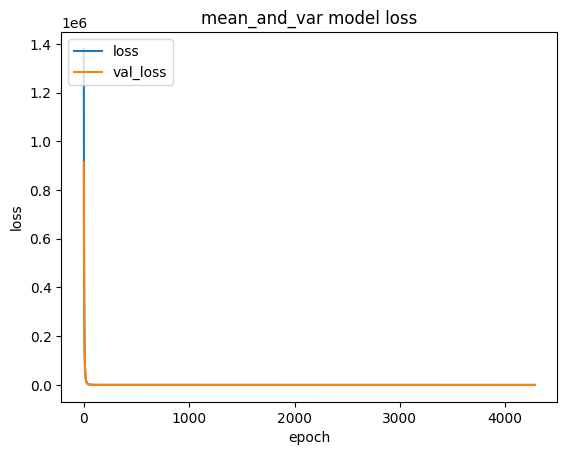

43/43 [==============================] - 0s 2ms/step - loss: 0.1144 - mae: 19.0129


[0.11441846936941147, 19.012935638427734]

In [ ]:
history, model = train_means_and_vars(X_train, Y_train, hidden_layers=[80, 80], epochs=5000, batch_size=100, lr = 0.001)
render_plot_loss(history, "mean_and_var")
model.evaluate(x=X_test, y=Y_test)

In [ ]:
model.save(get_model_save_location("dual_model.h5"), save_format="h5")
predictions = model.predict_on_batch(X_test)

# 3) A seperate model for variances (WORK IN PROGRESS)



Prepare the data slightly differently for variances. We need to group by sample site and find the variances at said sample sites.

In [ ]:
group_on = ['sample_site_lon', 'sample_site_lat', 'month_of_year']
grouped = df.groupby(group_on)

# ASSUMPTION: Taking the mean and variance of a sample site doesn't lower quality of the data.
# We need to do this to use KL-divergence loss.
means = grouped.mean()
O18_var = grouped.var()['O18']

# Merging results in some unreadable column names. Rename the oxygen columns.
merged = pd.merge(means, O18_var, on=group_on, how='inner').reset_index()
merged = merged.rename(columns={
    'O18_x': 'O18_mean',
    'O18_y': 'O18_var'})

# ...and drop sample_site_lon/sample_site_lat. These were keys used to identify
# sample sites. They are basically duplicates of the 'lat' 'lon' columns.
merged.drop(merged.columns[merged.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)
merged.drop('sample_site_lon', axis = 1, inplace = True)
merged.drop('sample_site_lat', axis = 1, inplace = True)


merged = categorize_months(merged)

train, test = train_test_split(merged, test_size=0.25, random_state=25)

# Target data: Mean and variance
Y_train_means = train[["O18_mean"]]
Y_test_means = test[["O18_mean"]]

Y_train_vars = train[["O18_var"]]
Y_test_vars = test[["O18_var"]]

# Features: Everything besides mean and variance
train.drop(train.columns[train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
X_train_means = train.drop(["O18_mean"], axis=1)
X_test_means = test.drop(["O18_mean"], axis=1)
X_train_vars = train.drop(["O18_var"], axis=1)
X_test_vars = test.drop(["O18_var"], axis=1)

# Normalize dataset for training variances.
X_train_vars = (X_train_vars-X_train_vars.min())/(X_train_vars.max()-X_train_vars.min())
X_test_vars = (X_test_vars-X_test_vars.min())/(X_test_vars.max()-X_train_vars.min())

Model definition. I tried experimenting with 3 different loss functions. They all produced gibberish:

In [ ]:
import tensorflow_probability as tfp

def kl_divergence_loss_1(real, predicted):
    real_value = tf.gather(real, [0], axis=1)
    real_variance = tf.gather(real, [1], axis=1) + 0.00000001
    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_variance = tf.gather(predicted, [1], axis=1) + 0.00000001

    kl_loss = -0.5 + tf.math.log(predicted_variance/real_variance) + \
     (tf.square(real_variance) + tf.square(real_value - predicted_value))/ \
     2*tf.square(predicted_variance)

    return tf.math.reduce_mean(tf.square(kl_loss))

def kl_divergence_loss_v2(real, predicted):
    kl_loss = real * tf.math.log(real/predicted)
    return tf.math.reduce_sum(kl_loss)

def negative_log_likelihood(real, predicted):
  return -predicted.log_prob(real)

# Similar architecture to means, but with different activation functions and
# dropout layers.
def train_vars(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float):
    shared_layers = []
    for num_nodes in hidden_layers:
        shared_layers.append(layers.Dense(
            num_nodes,
            activation='relu'))

    #Initialize input layers and connect them to shared layers.
    num_inputs = X.shape[1]
    inputs = keras.Input(shape=(num_inputs,))
    x = inputs
    x = layers.Dropout(0.5, input_shape=(num_inputs,))(x)
    for shared_layer in shared_layers:
        x = shared_layer(x)

    mean_output_node = layers.Dense(1, activation='relu', name='mean_output')(x)
    prob_output_node = tfp.layers.DistributionLambda(lambda t:
                tfp.distributions.Normal(loc   = t[...,:1],
                           scale=tf.math.softplus(0.005*t[...,1:])+0.001))(x)

    model = keras.Model(inputs=inputs, outputs=[prob_output_node])

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=negative_log_likelihood)
    print (model.summary())
    history = model.fit(X, Y, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=0.2, shuffle=True)
    return history, model

In [ ]:
history, vars_model = train_vars(X_train, Y_train, hidden_layers=[17, 80], epochs=1000, batch_size=500, lr=0.001)
render_plot_loss(history, "variance_output")

In [ ]:
vars_model.evaluate(x=X_test_vars, y=Y_test_vars)
predictions = vars_model.predict_on_batch(X_test_vars)
print(Y_test_means)

In [ ]:
vars_model.save(get_model_save_location("dnn_vars.h5"), save_format="h5")

# 4) Gaussian Process Regressor (hybrid model)

This is out of the scope of this file, but I already initialized the datasets here so I'll continue working on it here.

At a glance, this creates the best variances of any of the four models

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import pickle

# Intuition: Use Matern over the default RBF kernel since it seems to perform better
# on spatial problems? https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gpr = GaussianProcessRegressor(random_state=0).fit(X_train, Y_train)
gpr.score(X_train, Y_train)

with open(get_model_save_location('gpr_model.pkl'),'wb') as f:
    pickle.dump(gpr,f)

## Generating GeoTIFFs from the DNN

All of the code from the following block is (temporarily) copy and pasted from the library files.

In [17]:
from dataclasses import dataclass
from osgeo import gdal, gdal_array
from tqdm import tqdm
import math
import matplotlib.animation as animation

@dataclass
class AmazonGeoTiff:
  """Represents a geotiff from our dataset."""
  gdal_dataset: gdal.Dataset
  image_value_array: np.ndarray # ndarray of floats
  image_mask_array: np.ndarray # ndarray of uint8
  masked_image: np.ma.masked_array
  yearly_masked_image: np.ma.masked_array


@dataclass
class Bounds:
  """Represents geographic bounds and size information."""
  minx: float
  maxx: float
  miny: float
  maxy: float
  pixel_size_x: float
  pixel_size_y: float
  raster_size_x: float
  raster_size_y: float

  def to_matplotlib(self) -> List[float]:
      return [self.minx, self.maxx, self.miny, self.maxy]

def load_raster(path: str, use_only_band_index: int = -1) -> AmazonGeoTiff:
  """
  TODO: Refactor (is_single_band, etc., should be a better design)
  --> Find a way to simplify this logic. Maybe it needs to be more abstract.
  """
  dataset = gdal.Open(path, gdal.GA_ReadOnly)
  image_datatype = dataset.GetRasterBand(1).DataType
  mask_datatype = dataset.GetRasterBand(1).GetMaskBand().DataType
  image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                   dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
  mask = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

  if use_only_band_index == -1:
    if dataset.RasterCount != 12 and dataset.RasterCount != 1:
      raise ValueError(f"Expected 12 raster bands (one for each month) or one annual average, but found {dataset.RasterCount}")
    if dataset.RasterCount == 1:
      use_only_band_index = 0

  is_single_band = use_only_band_index != -1

  if is_single_band and use_only_band_index >= dataset.RasterCount:
    raise IndexError(f"Specified raster band index {use_only_band_index}"
                     f" but there are only {dataset.RasterCount} rasters")

  for band_index in range(12):
    band = dataset.GetRasterBand(use_only_band_index+1 if is_single_band else band_index+1)
    image[:, :, band_index] = band.ReadAsArray()
    mask[:, :, band_index] = band.GetMaskBand().ReadAsArray()
  masked_image = np.ma.masked_where(mask == 0, image)
  yearly_masked_image = masked_image.mean(axis=2)

  return AmazonGeoTiff(dataset, image, mask, masked_image, yearly_masked_image)

def get_extent(dataset):
  geoTransform = dataset.GetGeoTransform()
  minx = geoTransform[0]
  maxy = geoTransform[3]
  maxx = minx + geoTransform[1] * dataset.RasterXSize
  miny = maxy + geoTransform[5] * dataset.RasterYSize
  return Bounds(minx, maxx, miny, maxy, geoTransform[1], geoTransform[5], dataset.RasterXSize, dataset.RasterYSize)

def coords_to_indices(bounds: Bounds, x: float, y: float):
  if x < bounds.minx or x > bounds.maxx or y < bounds.miny or y > bounds.maxy:
    raise ValueError("Coordinates out of bounds")

  # X => lat, Y => lon
  x_idx = bounds.raster_size_y - int(math.ceil((y - bounds.miny) / abs(bounds.pixel_size_y)))
  y_idx = int((x - bounds.minx) / abs(bounds.pixel_size_x))

  return x_idx, y_idx

def get_data_at_coords(dataset: AmazonGeoTiff, x: float, y: float, month: int) -> float:
  # x = longitude
  # y = latitude
  bounds = get_extent(dataset.gdal_dataset)
  x_idx, y_idx = coords_to_indices(bounds, x, y)
  if month == -1:
    value = dataset.yearly_masked_image[x_idx, y_idx]
  else:
    value = dataset.masked_image[x_idx, y_idx, month]
  if np.ma.is_masked(value):
    raise ValueError("Coordinates are masked")
  else:
    return value

def animate(geotiff: AmazonGeoTiff, nSeconds, fps):
  fig = plt.figure( figsize=(8,8) )

  months = []
  labels = []
  for m in range(12):
    months.append(geotiff.masked_image[:,:,m])
    labels.append(f"Month: {m+1}")
  a = months[0]
  extent = get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  im = fig.axes[0].imshow(a, interpolation='none', aspect='auto', extent = extent)
  txt = fig.text(0.3,0,"", fontsize=24)
  fig.colorbar(im)

  def animate_func(i):
    if i % fps == 0:
      print( '.', end ='' )

    im.set_array(months[i])
    txt.set_text(labels[i])
    return [im, txt]

  anim = animation.FuncAnimation(
      fig,
      animate_func,
      frames = nSeconds * fps,
      interval = 1000 / fps, # in ms
  )
  plt.close()

  return anim


The following code is new stuff, and used to generate a 12 GeoTIFFs (one for each month) from the model.

In [23]:
def reformat_gpr(predictions):
  return np.column_stack((predictions[0], predictions[1]))

def get_predictions_at_each_pixel(
    monthly: bool,
    geotiffs: dict[str, AmazonGeoTiff],
    bounds: Bounds,
    model=None,
    gpr=None):

  # Initialize a blank plane representing means and variance.
  predicted_means_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))
  predicted_vars_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))

  for month in range (0, 12 if monthly else 1):
    for x_idx, x in enumerate(tqdm(np.arange(bounds.minx, bounds.maxx, bounds.pixel_size_x, dtype=float))):
      rows = []
      row_indexes = []
      for y_idx, y in enumerate(np.arange(bounds.miny, bounds.maxy, -bounds.pixel_size_y, dtype=float)):
        # Row should contain all the features needed to predict.
        row = {}

        # Surround in try/except as we will be trying to fetch out of bounds data.
        try:
          for geotiff_label, geotiff in geotiffs.items():
            row[geotiff_label] = get_data_at_coords(geotiff, x, y, month)
        except (ValueError, IndexError):
          continue # masked and out-of-bounds coordinates
        row["lon"] = x
        row["lat"] = y
        
        # Set all month_of_year binary variables to 0 unless it refers to `month`.
        for i in range(0,12):
          row["month_of_year_" + str(i)] = (1 if i == month else 0)
        
        rows.append(row)
        row_indexes.append((y_idx,month,))
      if (len(rows) > 0):
        X = pd.DataFrame.from_dict(rows)
        predictions = model.predict_on_batch(X) if model else reformat_gpr(gpr.predict(X, return_std=True))

        means_np = predictions[:, 0]
        for prediction, (y_idx, month_idx) in zip(means_np, row_indexes):
          predicted_means_np.mask[x_idx,y_idx,month_idx] = False # unmask since we have data
          predicted_means_np.data[x_idx,y_idx,month_idx] = prediction
        vars_np = predictions[:, 1]
        for prediction, (y_idx, month_idx) in zip (vars_np, row_indexes):
          predicted_vars_np.mask[x_idx, y_idx, month_idx] = False
          predicted_vars_np.data[x_idx, y_idx, month_idx] = prediction

  return predicted_means_np, predicted_vars_np

In [19]:
relative_humidity_geotiff = load_raster(get_raster_path_from_params("R.rh_Stack.tif"))
temperature_geotiff = load_raster(get_raster_path_from_params("Temperatura_Stack.tif"))
vapor_pressure_deficit_geotiff = load_raster(get_raster_path_from_params("R.vpd_Stack.tif"))
atmosphere_isoscape_geotiff = load_raster(get_raster_path_from_params("Iso_Oxi_Stack.tif"))

name_to_geotiff = {
    "rh": relative_humidity_geotiff,
    "temp" : temperature_geotiff,
    "vpd" : vapor_pressure_deficit_geotiff,
    "atmosphere_oxygen_ratio" : atmosphere_isoscape_geotiff,
}

# We need the borders of the map. Pick one geotiff at random and use that as the extent.
bounds =  get_extent(atmosphere_isoscape_geotiff.gdal_dataset)

Option 1: Use the tensorflow model.

In [ ]:
model = keras.models.load_model(get_model_save_location("dual_model.h5"), custom_objects={"mean_and_var_loss": mean_and_var_loss})
means_np, vars_np = get_predictions_at_each_pixel(
    monthly=True, geotiffs=name_to_geotiff, bounds=bounds, model=model)

Option 2: Use the GPR model.

(Note, GPR prediction is slow... this takes an hour to run)

In [ ]:
import pickle
with open(get_model_save_location('gpr_model.pkl'), 'rb') as f:
  gpr = pickle.load(f)
print(gpr.feature_names_in_)
means_np, vars_np = get_predictions_at_each_pixel(
    monthly=True, geotiffs=name_to_geotiff, bounds=bounds, gpr=gpr)

Driver code for saving the generated numpy values to GeoTIFFs, also copied straight from nicholas's colab.

In [26]:
from osgeo import gdal, gdal_array

def save_numpy_to_geotiff(bounds: Bounds, prediction: np.ma.MaskedArray, path: str):
  """Copy metadata from a base geotiff and write raster data + mask from `data`"""
  driver = gdal.GetDriverByName("GTiff")
  metadata = driver.GetMetadata()
  if metadata.get(gdal.DCAP_CREATE) != "YES":
    raise RuntimeError("GTiff driver does not support required method Create().")
  if metadata.get(gdal.DCAP_CREATECOPY) != "YES":
    raise RuntimeError("GTiff driver does not support required method CreateCopy().")

  dataset = driver.Create(path, bounds.raster_size_x, bounds.raster_size_y, prediction.shape[2], eType=gdal.GDT_Float64)
  dataset.SetGeoTransform([bounds.minx, bounds.pixel_size_x, 0, bounds.maxy, 0, bounds.pixel_size_y])
  dataset.SetProjection('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]')

  #dataset = driver.CreateCopy(path, base.gdal_dataset, strict=0)
  if len(prediction.shape) != 3 or prediction.shape[0] != bounds.raster_size_x or prediction.shape[1] != bounds.raster_size_y:
    raise ValueError("Shape of prediction does not match base geotiff")
  #if prediction.shape[2] > base.gdal_dataset.RasterCount:
  #  raise ValueError(f"Expected fewer than {dataset.RasterCount} bands in prediction but found {prediction.shape[2]}")

  prediction_transformed = np.flip(np.transpose(prediction, axes=[1,0,2]), axis=0)
  for band_index in range(dataset.RasterCount):
    band = dataset.GetRasterBand(band_index+1)
    if band.CreateMaskBand(0) == gdal.CE_Failure:
      raise RuntimeError("Failed to create mask band")
    mask_band = band.GetMaskBand()
    band.WriteArray(np.choose(prediction_transformed[:, :, band_index].mask, (prediction_transformed[:, :, band_index].data,np.array(band.GetNoDataValue()),)))
    mask_band.WriteArray(np.logical_not(prediction_transformed[:, :, band_index].mask))

save_numpy_to_geotiff(bounds, means_np, get_output_raster_path_from_params("predicted_isoscape_gpr_means.tiff"))
save_numpy_to_geotiff(bounds, vars_np, get_output_raster_path_from_params("predicted_isoscape_gpr_vars.tiff"))

Animations! We only do this with the hybrid model right now.

In [27]:
from matplotlib import rc
rc('animation', html='jshtml')

dnn2_means = load_raster(get_output_raster_path_from_params("predicted_isoscape_gpr_means.tiff"))
animate(dnn2_means, 12, 1)

.............

In [28]:
dnn2_vars = load_raster(get_output_raster_path_from_params("predicted_isoscape_gpr_vars.tiff"))
animate(dnn2_vars, 12, 1)

.............